In [6]:
#import libraries
import numpy as np
import pandas as pd
import os
from random import choice, randint
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam




In [7]:
#load the dataset into a pandas dataframe
file_path = os.path.join('data', 'Booking_Data_Cleaned.csv')
df = pd.read_csv(file_path)

In [8]:
df.head()

,Hotel,Booking Date,Arrival Date,Lead Time,Nights,Guests,Distribution Channel,Customer Type,Country,Deposit Type,...,Stay Duration Category,Revenue Category,Revenue Loss Category,ADR Category,Booking Month,Booking Day,Arrival Month,Arrival Day,Booking Year,Arrival Year
0,Resort,2014-07-24,2015-07-01,342,0,2,Direct,Transient,Portugal,No Deposit,...,short,low,low,low,July,Thursday,July,Wednesday,2014,2015
1,Resort,2015-06-24,2015-07-01,7,1,1,Direct,Transient,United Kingdom,No Deposit,...,short,low,low,low,June,Wednesday,July,Wednesday,2015,2015
2,Resort,2015-06-18,2015-07-01,13,1,1,Corporate,Transient,United Kingdom,No Deposit,...,short,low,low,low,June,Thursday,July,Wednesday,2015,2015
3,Resort,2015-06-17,2015-07-01,14,2,2,Online Travel Agent,Transient,United Kingdom,No Deposit,...,short,medium,low,low,June,Wednesday,July,Wednesday,2015,2015
4,Resort,2015-06-17,2015-07-01,14,2,2,Online Travel Agent,Transient,United Kingdom,No Deposit,...,short,medium,low,low,June,Wednesday,July,Wednesday,2015,2015


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111944 entries, 0 to 111943
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Hotel                   111944 non-null  object
 1   Booking Date            111944 non-null  object
 2   Arrival Date            111944 non-null  object
 3   Lead Time               111944 non-null  int64 
 4   Nights                  111944 non-null  int64 
 5   Guests                  111944 non-null  int64 
 6   Distribution Channel    111944 non-null  object
 7   Customer Type           111944 non-null  object
 8   Country                 111944 non-null  object
 9   Deposit Type            111944 non-null  object
 10  Avg Daily Rate          111944 non-null  int64 
 11  Status                  111944 non-null  object
 12  Status Update           111944 non-null  object
 13  Cancelled (0/1)         111944 non-null  int64 
 14  Revenue                 111944 non-n

In [10]:
# Dropping the original date columns if they are no longer needed
df = df.drop(['Booking Date', 'Arrival Date'], axis=1)

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111944 entries, 0 to 111943
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Hotel                   111944 non-null  object
 1   Lead Time               111944 non-null  int64 
 2   Nights                  111944 non-null  int64 
 3   Guests                  111944 non-null  int64 
 4   Distribution Channel    111944 non-null  object
 5   Customer Type           111944 non-null  object
 6   Country                 111944 non-null  object
 7   Deposit Type            111944 non-null  object
 8   Avg Daily Rate          111944 non-null  int64 
 9   Status                  111944 non-null  object
 10  Status Update           111944 non-null  object
 11  Cancelled (0/1)         111944 non-null  int64 
 12  Revenue                 111944 non-null  int64 
 13  Revenue Loss            111944 non-null  int64 
 14  Guest Category          111944 non-n

Encode the Categorical Features

In [12]:
# Encoding categorical features
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = le.fit_transform(df[column])


In [13]:
df.head()

,Hotel,Lead Time,Nights,Guests,Distribution Channel,Customer Type,Country,Deposit Type,Avg Daily Rate,Status,...,Stay Duration Category,Revenue Category,Revenue Loss Category,ADR Category,Booking Month,Booking Day,Arrival Month,Arrival Day,Booking Year,Arrival Year
0,1,342,0,2,1,2,126,0,0,1,...,2,1,1,1,5,4,5,6,2014,2015
1,1,7,1,1,1,2,163,0,75,1,...,2,1,1,1,6,6,5,6,2015,2015
2,1,13,1,1,0,2,163,0,75,1,...,2,1,1,1,6,4,5,6,2015,2015
3,1,14,2,2,3,2,163,0,98,1,...,2,2,1,1,6,6,5,6,2015,2015
4,1,14,2,2,3,2,163,0,98,1,...,2,2,1,1,6,6,5,6,2015,2015


In [14]:
print(df.shape)
print(df.info())

(111944, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111944 entries, 0 to 111943
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   Hotel                   111944 non-null  int32
 1   Lead Time               111944 non-null  int64
 2   Nights                  111944 non-null  int64
 3   Guests                  111944 non-null  int64
 4   Distribution Channel    111944 non-null  int32
 5   Customer Type           111944 non-null  int32
 6   Country                 111944 non-null  int32
 7   Deposit Type            111944 non-null  int32
 8   Avg Daily Rate          111944 non-null  int64
 9   Status                  111944 non-null  int32
 10  Status Update           111944 non-null  int32
 11  Cancelled (0/1)         111944 non-null  int64
 12  Revenue                 111944 non-null  int64
 13  Revenue Loss            111944 non-null  int64
 14  Guest Category          111944 non-null

Check for imbalance in dataset

In [15]:
# Separating features and target variable
X = df.drop('Cancelled (0/1)', axis=1)
y = df['Cancelled (0/1)']
column_names = X.columns.tolist()
print(column_names)

# Identifying categorical columns for one-hot encoding
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Create a column transformer with appropriate transformers for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

# Fit the preprocessor and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# Checking the balance after SMOTE
print(f"Before SMOTE, counts of label '1': {sum(y_train == 1)}")
print(f"Before SMOTE, counts of label '0': {sum(y_train == 0)}\n")
print(f"After SMOTE, counts of label '1': {sum(y_train_smote == 1)}")
print(f"After SMOTE, counts of label '0': {sum(y_train_smote == 0)}")

X_train = X_train_smote
y_train = y_train_smote
print("X train shape: ", X_train.shape)
print("Y train shape: ",y_train.shape)
print("X test shape: ", X_test.shape)
print("Y test shape: ",y_test.shape)
print("X train type: ", type(X_train))

['Hotel', 'Lead Time', 'Nights', 'Guests', 'Distribution Channel', 'Customer Type', 'Country', 'Deposit Type', 'Avg Daily Rate', 'Status', 'Status Update', 'Revenue', 'Revenue Loss', 'Guest Category', 'Lead Time Category', 'Stay Duration Category', 'Revenue Category', 'Revenue Loss Category', 'ADR Category', 'Booking Month', 'Booking Day', 'Arrival Month', 'Arrival Day', 'Booking Year', 'Arrival Year']
Index([], dtype='object')
Before SMOTE, counts of label '1': 32084
Before SMOTE, counts of label '0': 57471

After SMOTE, counts of label '1': 57471
After SMOTE, counts of label '0': 57471
X train shape:  (114942, 25)
Y train shape:  (114942,)
X test shape:  (22389, 25)
Y test shape:  (22389,)
X train type:  <class 'numpy.ndarray'>


In [16]:
# Initializing the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting the model
rf.fit(X_train, y_train)

# Predicting the test set results
y_pred = rf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Getting feature importances
feature_importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print("Accuracy: ", accuracy)
print("Classification Report: \n", report)
print("Feature Importances: \n", importance_df.head(10))

Accuracy:  0.9566304881861628
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.97     14368
           1       0.89      1.00      0.94      8021

    accuracy                           0.96     22389
   macro avg       0.95      0.97      0.95     22389
weighted avg       0.96      0.96      0.96     22389

Feature Importances: 
                   Feature  Importance
9                  Status    0.444078
12           Revenue Loss    0.183058
7            Deposit Type    0.120652
11                Revenue    0.096969
17  Revenue Loss Category    0.044283
16       Revenue Category    0.024983
1               Lead Time    0.019854
6                 Country    0.019689
10          Status Update    0.011630
14     Lead Time Category    0.009959


c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


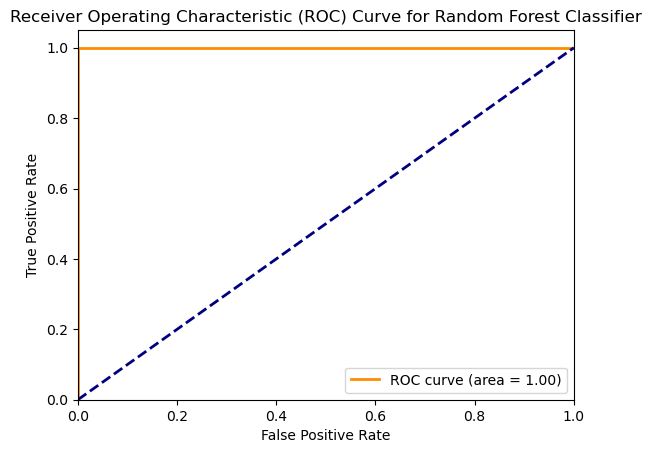

In [17]:
y_score = rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Dropping columns that are directly related to the outcome or post-outcome
columns_to_drop = ['Revenue Loss', 'Revenue Category', 'Revenue Loss Category']

# Dropping the identified columns from the dataset
X_reduced = X.drop(columns_to_drop, axis=1)
print("Before dropping cols shape is: ",X.shape)
print("After dropping cols shape is: ",X_reduced.shape)

# Splitting the reduced dataset into training and testing sets
X_train_reduced, X_test_reduced, y_train_reduced, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Identifying categorical and numerical columns for the reduced dataset
categorical_features = X_train_reduced.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train_reduced.select_dtypes(exclude=['object', 'category']).columns.tolist()

print("Categorical features: ", categorical_features)
print("Numerical features: ", numerical_features)

# Create a column transformer with appropriate transformers for numerical data
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_features)]
)
# Fit the preprocessor and transform the training data
X_train_red_processed = preprocessor.fit_transform(X_train_reduced)

# Fit SMOTE to the training data
X_train_red_smote, y_train_smote = smote.fit_resample(X_train_red_processed, y_train_reduced)

# Fitting the Random Forest model on the reduced dataset
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_red_smote, y_train_smote)

# Predicting the test set results
y_pred_reduced_rf = rf_reduced.predict(X_test_reduced)

# Evaluating the model on the reduced dataset
accuracy_reduced = accuracy_score(y_test, y_pred_reduced_rf)
report_reduced = classification_report(y_test, y_pred_reduced_rf)

# Getting feature importances from the reduced model
feature_importances_reduced = rf_reduced.feature_importances_
features_reduced = X_reduced.columns
importance_df_reduced = pd.DataFrame({'Feature': features_reduced, 'Importance': feature_importances_reduced}).sort_values(by='Importance', ascending=False)

print("Results after dropping columns directly related to the outcome or post-outcome:")
print("Random Forest Classifier:")
print("Accuracy:", accuracy_reduced)
print("Classification Report:\n", report_reduced)
print("Top 10 most important features:\n", importance_df_reduced.head(10))



Before dropping cols shape is:  (111944, 25)
After dropping cols shape is:  (111944, 22)
Categorical features:  []
Numerical features:  ['Hotel', 'Lead Time', 'Nights', 'Guests', 'Distribution Channel', 'Customer Type', 'Country', 'Deposit Type', 'Avg Daily Rate', 'Status', 'Status Update', 'Revenue', 'Guest Category', 'Lead Time Category', 'Stay Duration Category', 'ADR Category', 'Booking Month', 'Booking Day', 'Arrival Month', 'Arrival Day', 'Booking Year', 'Arrival Year']
Results after dropping columns directly related to the outcome or post-outcome:
Random Forest Classifier:
Accuracy: 0.6490240743222118
Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.78     14301
           1       1.00      0.03      0.06      8088

    accuracy                           0.65     22389
   macro avg       0.82      0.51      0.42     22389
weighted avg       0.77      0.65      0.52     22389

Top 10 most important features:
 

c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC-AUC for Random forest

c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


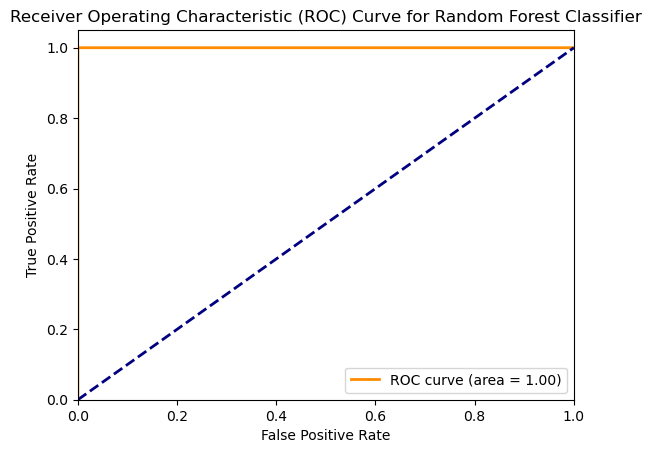

In [19]:
y_score = rf_reduced.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

**Logistic Regression**

In [20]:
#Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
print("Logistic Regression Classifier:")
print("Accuracy: ",accuracy_lr)
print("Classification report: ",report_lr)


Logistic Regression Classifier:
Accuracy:  0.3612488275492429
Classification report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00     14301
           1       0.36      1.00      0.53      8088

    accuracy                           0.36     22389
   macro avg       0.18      0.50      0.27     22389
weighted avg       0.13      0.36      0.19     22389



c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 

c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


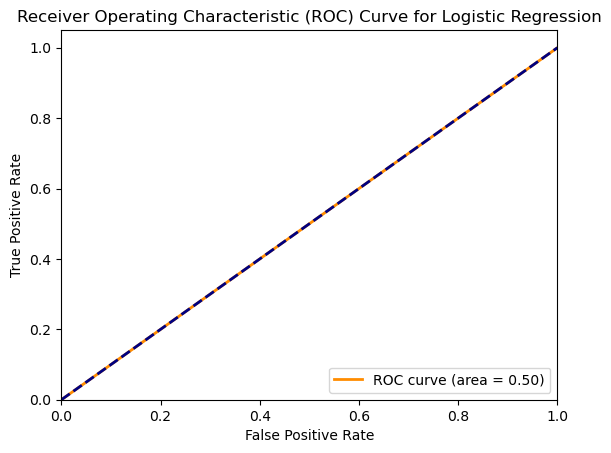

In [21]:
y_score = lr.predict_proba(X_test)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [22]:
#Logistic Regression
lr_red = LogisticRegression(max_iter=1000, random_state=42)
lr_red.fit(X_train_red_smote, y_train_smote)
y_pred_lr = lr_red.predict(X_test_reduced)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
print("Logistic Regression Classifier:")
print("Accuracy: ",accuracy_lr)
print("Classification report: ",report_lr)


Logistic Regression Classifier:
Accuracy:  0.6143641967037384
Classification report:                precision    recall  f1-score   support

           0       0.89      0.45      0.60     14301
           1       0.48      0.90      0.63      8088

    accuracy                           0.61     22389
   macro avg       0.69      0.68      0.61     22389
weighted avg       0.74      0.61      0.61     22389



c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ROC-AUC for Logistic Regression

c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


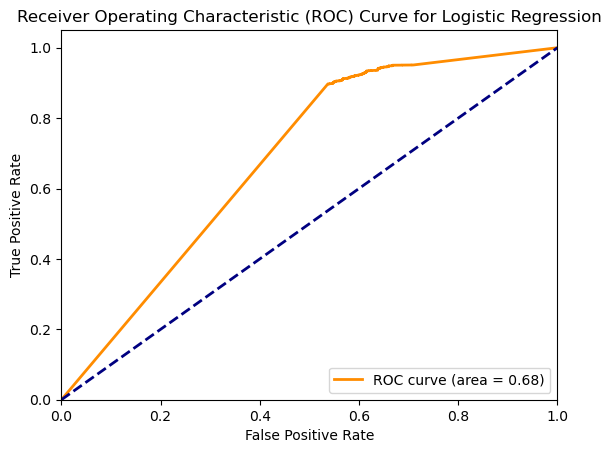

In [23]:
y_score = lr_red.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

**XGBoost**

In [24]:
#XGBClassifier without feature selected data
Xgb = XGBClassifier(max_iter=1000, random_state=42)
Xgb.fit(X_train, y_train)
y_pred_xg = Xgb.predict(X_test)
accuracy_xg = accuracy_score(y_test, y_pred_xg)
report_xg = classification_report(y_test, y_pred_xg)
print("XGBoost Classifier:")
print("Accuracy: ",accuracy_xg)
print("Classification report: ",report_xg)


[05:03:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_iter" } are not used.

XGBoost Classifier:
Accuracy:  0.5399973201125553
Classification report:                precision    recall  f1-score   support

           0       0.64      0.64      0.64     14301
           1       0.36      0.36      0.36      8088

    accuracy                           0.54     22389
   macro avg       0.50      0.50      0.50     22389
weighted avg       0.54      0.54      0.54     22389



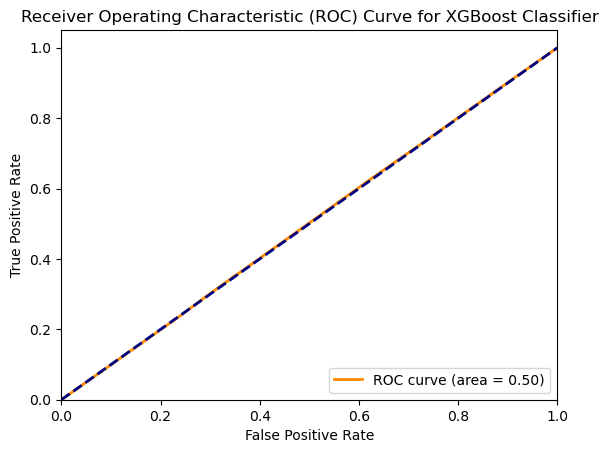

In [25]:

y_score = Xgb.predict_proba(X_test)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()

In [26]:
#XGBoost Classifier
xgb_red = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_red.fit(X_train_red_smote, y_train_smote)
y_pred_xgb = xgb_red.predict(X_test_reduced)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
print("XGBoost Classifier:")
print("Accuracy: ",accuracy_xgb)
print("Classification report: ",report_xgb)


c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost Classifier:
Accuracy:  0.3612488275492429
Classification report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00     14301
           1       0.36      1.00      0.53      8088

    accuracy                           0.36     22389
   macro avg       0.18      0.50      0.27     22389
weighted avg       0.13      0.36      0.19     22389



c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC-AUC for XGBoost

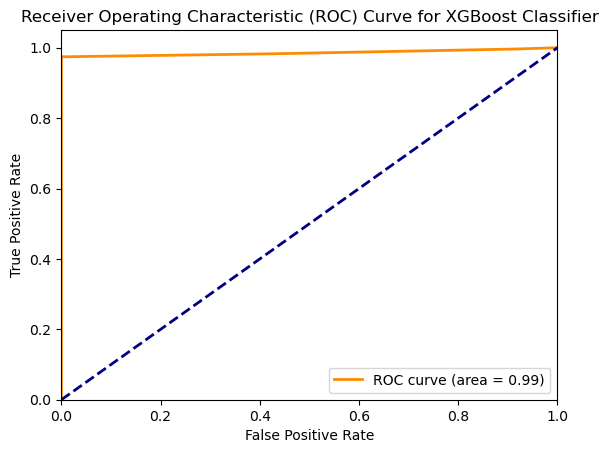

In [27]:

y_score = xgb_red.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()

MLP Classifier

In [28]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', alpha=0.001, learning_rate_init=0.001, 
                solver='adam', random_state=42, early_stopping=True, validation_fraction=0.1,  n_iter_no_change=10)

# Train the classifier
mlp.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_mlp = mlp.predict(X_test_scaled)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_mlp)
print("MLP Classifier:")
print("Accuracy:", accuracy)
classification_report_mlp = classification_report(y_test, y_pred_mlp)
print("Classification Report:\n", classification_report_mlp)


c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


MLP Classifier:
Accuracy: 0.45267765420519007
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.32      0.43     14301
           1       0.36      0.68      0.47      8088

    accuracy                           0.45     22389
   macro avg       0.50      0.50      0.45     22389
weighted avg       0.54      0.45      0.45     22389



In [33]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_red_smote)
X_test_scaled = scaler.transform(X_test_reduced)
# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(200,), activation='relu', alpha=0.001, learning_rate_init=0.001, 
                solver='adam', random_state=42, early_stopping=True, validation_fraction=0.1,  n_iter_no_change=10, verbose=True)

# Train the classifier
mlp.fit(X_train_scaled, y_train_smote)

# Make predictions on the test set
y_pred_mlp = mlp.predict(X_test_scaled)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_mlp)
print("MLP Classifier:")
print("Accuracy:", accuracy)
classification_report_mlp = classification_report(y_test, y_pred_mlp)
print("Classification Report:\n", classification_report_mlp)


c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 1, loss = 0.10729281
Validation score: 0.994265
Iteration 2, loss = 0.01173067
Validation score: 0.998870
Iteration 3, loss = 0.00337385
Validation score: 0.999652
Iteration 4, loss = 0.00153002
Validation score: 0.999739
Iteration 5, loss = 0.00087880
Validation score: 0.999826
Iteration 6, loss = 0.00060313
Validation score: 0.999826
Iteration 7, loss = 0.00047455
Validation score: 0.999826
Iteration 8, loss = 0.00040281
Validation score: 0.999826
Iteration 9, loss = 0.00036036
Validation score: 0.999913
Iteration 10, loss = 0.00032991
Validation score: 0.999913
Iteration 11, loss = 0.00030954
Validation score: 0.999913
Iteration 12, loss = 0.00029256
Validation score: 1.000000
Iteration 13, loss = 0.00027691
Validation score: 0.999913
Iteration 14, loss = 0.00026160
Validation score: 1.000000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLP Classifier:
Accuracy: 0.8492563312340882
Classification Report:
               precisi

c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


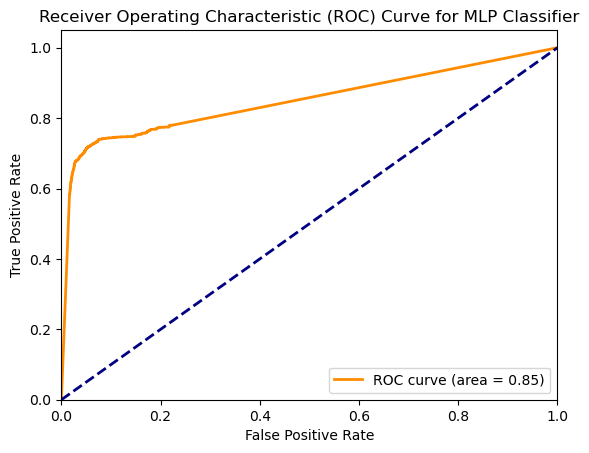

In [36]:
#ROC curve for MLP Classifier
y_score = mlp.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for MLP Classifier')
plt.legend(loc="lower right")
plt.show()

Using Tensorflow Dense Layer

In [44]:
#using tensorflow and keras
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_red_smote)
X_test_scaled = scaler.transform(X_test_reduced)

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))  # Input layer and first hidden layer
model.add(Dense(32, activation='relu'))# Second hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer with one neuron since it's binary classification

# Compile the model
model.compile(loss='binary_crossentropy',  # Suitable loss function for binary classification
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_smote, 
                    validation_split=0.1,  # Use 10% of the training data as validation data
                    epochs=20,  # Number of epochs (iterations over the entire dataset)
                    batch_size=32,  # Number of samples per gradient update
                    verbose=1)

# Predict classes using the trained model
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype("int32")



Epoch 1/20


c:\Users\1ga17\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


3237/3237 [==============================] - 8s 2ms/step - loss: 0.1571 - accuracy: 0.9643 - val_loss: 0.0770 - val_accuracy: 0.9739
Epoch 2/20
3237/3237 [==============================] - 6s 2ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0100 - val_accuracy: 0.9974
Epoch 3/20
3237/3237 [==============================] - 6s 2ms/step - loss: 0.0045 - accuracy: 0.9994 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/20
3237/3237 [==============================] - 6s 2ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 3.9311e-04 - val_accuracy: 1.0000
Epoch 5/20
3237/3237 [==============================] - 7s 2ms/step - loss: 3.6908e-04 - accuracy: 1.0000 - val_loss: 1.6247e-04 - val_accuracy: 1.0000
Epoch 6/20
3237/3237 [==============================] - 6s 2ms/step - loss: 1.4609e-04 - accuracy: 1.0000 - val_loss: 6.9097e-05 - val_accuracy: 1.0000
Epoch 7/20
3237/3237 [==============================] - 6s 2ms/step - loss: 5.9652e-05 - accuracy: 1.0000 - val_loss: 4.8893e-0

In [45]:
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_nn)
print("Simple Neural Network Classifier:")
print("Accuracy:", accuracy)
classification_report_nn = classification_report(y_test, y_pred_nn)
print("Classification Report:\n", classification_report_nn)

Simple Neural Network Classifier:
Accuracy: 0.7820804859529233
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85     14301
           1       0.92      0.43      0.59      8088

    accuracy                           0.78     22389
   macro avg       0.84      0.71      0.72     22389
weighted avg       0.81      0.78      0.76     22389

